# Audio Data Preparation and Augmentation

## Overview

This notebook will be a good start on preparing and analyzing audio data. 

## Setup 

Install required packages, and restart runtime

In [ ]:
# !pip install tensorflow-io

## Usage

### Read an Audio File

In TensorFlow IO, class [tfio.audio.AudioIOTensor](https://www.tensorflow.org/io/api_docs/python/tfio/audio/AudioIOTensor) allows you to read an audio file into a lazy-loaded IOTensor:

In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd

audio = tfio.audio.AudioIOTensor('gs://cloud-samples-tests/speech/brooklyn.flac')

print(audio)

2022-04-20 08:51:06.109826: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-04-20 08:51:06.242270: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-20 08:51:06.588561: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "INTERNAL: Couldn't parse JSON response from OAuth server.".


<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>


In [2]:
audio.shape

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([28979,     1])>

In [3]:
print(audio[:])
print('------------')
print(len(audio[:]))
print('------------')
print(pd.Series(audio).unique())
print('------------')
print(audio[0])

tf.Tensor(
[[-184]
 [-181]
 [-156]
 ...
 [  56]
 [  81]
 [  83]], shape=(28979, 1), dtype=int16)
------------
28979
------------
[<AudioIOTensor: shape=[28979     1], dtype=<dtype: 'int16'>, rate=16000>]
------------
tf.Tensor([-184], shape=(1,), dtype=int16)


In [4]:
b = audio.to_tensor()

In [5]:
len(b)

28979

In [6]:
b

<tf.Tensor: shape=(28979, 1), dtype=int16, numpy=
array([[-184],
       [-181],
       [-156],
       ...,
       [  56],
       [  81],
       [  83]], dtype=int16)>

In [14]:
c = pd.Series(b[:])

In [20]:
c

0        (tf.Tensor(-184, shape=(), dtype=int16),)
1        (tf.Tensor(-181, shape=(), dtype=int16),)
2        (tf.Tensor(-156, shape=(), dtype=int16),)
3        (tf.Tensor(-148, shape=(), dtype=int16),)
4        (tf.Tensor(-151, shape=(), dtype=int16),)
                           ...                    
28974      (tf.Tensor(77, shape=(), dtype=int16),)
28975      (tf.Tensor(97, shape=(), dtype=int16),)
28976      (tf.Tensor(56, shape=(), dtype=int16),)
28977      (tf.Tensor(81, shape=(), dtype=int16),)
28978      (tf.Tensor(83, shape=(), dtype=int16),)
Length: 28979, dtype: object

# Takeaways

* It seems as if the data stored in 'audio' came in as an IOTensor, but was converted into a tf.Tensor

In the above example, the Flac file `brooklyn.flac` is from a publicly accessible audio clip in [google cloud](https://cloud.google.com/speech-to-text/docs/quickstart-gcloud).

The GCS address `gs://cloud-samples-tests/speech/brooklyn.flac` are used directly because GCS is a supported file system in TensorFlow. In addition to `Flac` format, `WAV`, `Ogg`, `MP3`, and `MP4A` are also supported by `AudioIOTensor` with automatic file format detection.

`AudioIOTensor` is lazy-loaded so only shape, dtype, and sample rate are shown initially. The shape of the `AudioIOTensor` is represented as `[samples, channels]`, which means the audio clip you loaded is mono channel with `28979` samples in `int16`.

The content of the audio clip will only be read as needed, either by converting `AudioIOTensor` to `Tensor` through `to_tensor()`, or though slicing. Slicing is especially useful when only a small portion of a large audio clip is needed:

# Takeaways

* GCS(Google Cloud Storage)
* AudioIOTensor is represented as [samples, channels]
* AudioIOTensor data must be converted to a Tensor using to_tensor() or can be processed using slicing. 
* Slicing is useful when small portions of large audio clips are needed.

[tf.squeeze](https://www.tensorflow.org/api_docs/python/tf/squeeze) removes dimensions of size 1 from the shape of a tensor.

In [21]:
audio_slice = audio[100:]

# remove the last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])

print(audio_tensor)

tf.Tensor([16 39 66 ... 56 81 83], shape=(28879,), dtype=int16)


In [24]:
pd.Series(audio_tensor).value_counts()

-93      30
-55      30
-36      29
 102     29
 85      29
         ..
-3717     1
-1670     1
-5768     1
 5768     1
 4117     1
Length: 9472, dtype: int64

In [28]:
max(audio_tensor), min(audio_tensor)

(<tf.Tensor: shape=(), dtype=int16, numpy=16547>,
 <tf.Tensor: shape=(), dtype=int16, numpy=-13462>)

# Takeaways
* This particular tensor has a length of ~29,000 values with ~9500 unique values.
* Max value: 16547
* Min value: -13462

### The audio can be played through:

In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate = audio.rate.numpy())

# Takeaways
* Don't know how to acess this audio.

It is more convenient to convert tensors into float numbers and express the audio clip as a graph:

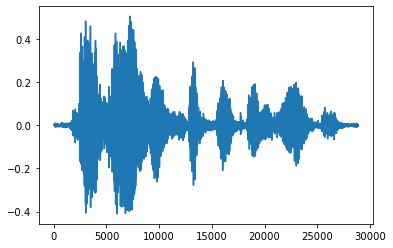

In [26]:
import matplotlib.pyplot as plt

tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

# Takeaways
* The values were converted to a float datatype and then divided by 32768.0. 
* I'll have to find the significance of '32768.0'.

### Trim the noise

Sometimes it makes sense to trim the noise from the audio, which could be done through API `tfio.audio.trim`. Returned from the API is a pair of `[start, stop]` position of the segment:

tf.Tensor([ 2398 23546], shape=(2,), dtype=int64)
tf.Tensor(2398, shape=(), dtype=int64) tf.Tensor(23546, shape=(), dtype=int64)


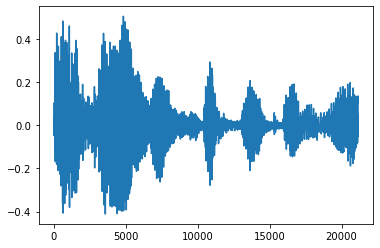

In [29]:
position = tfio.audio.trim(tensor, axis=0, epsilon=0.1)
print(position)

start = position[0]
stop = position[1]
print(start, stop)

processed = tensor[start:stop]

plt.figure()
plt.plot(processed.numpy())

# Takeaways
* The unedited audio data has 8 peaks and the edited audio data has 7 peaks.

### Fade In and Fade Out

One useful audio engineering technique is fade, which gradually increases or decreases audio signals. This can be done through [tfio.qudio.fade](https://www.tensorflow.org/io/api_docs/python/tfio/audio/fade). [tfio.qudio.fade](https://www.tensorflow.org/io/api_docs/python/tfio/audio/fade) supports different shapes of fades such as `linear`, `logarithmic`, or `exponential`:

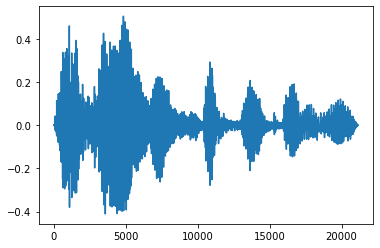

In [30]:
fade = tfio.audio.fade(
    processed, fade_in = 1000, fade_out = 2000, mode = 'logarithmic')

plt.figure()
plt.plot(fade.numpy())

# Takeaways
* The '.fade()' function gradually increases/decreases the scale of the audio data until it reaches 100%.
* The 'fade_in/fade_out' arguments is the length of the fade.

### Spectrogram

Advanced audio processing often works on frequency changes over time. In `tensorflow-io` a waveform can be converted to spectrogram through `tfio.audio.spectrogram`:

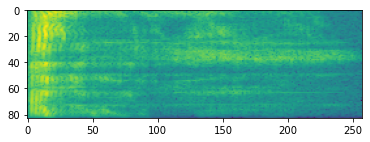

In [31]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(
    fade, nfft = 512, window = 512, stride = 256
)

plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

# Takeaways
* 'nfft' is the size of the FFT.
* 'window' is the size of the window.
* 'stride' is the size of hops between windows.
* With respect to the vertical axis, the positive direction is downward.

Additional transformation to different scales are also possible:


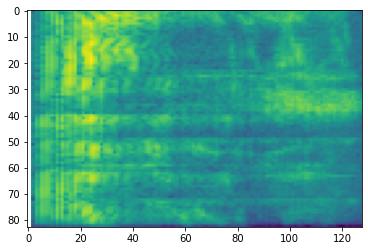

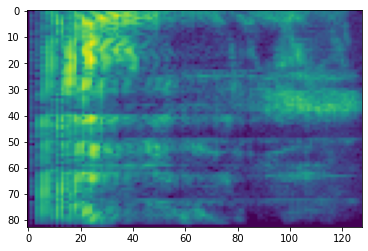

In [32]:
# Convert to mel-spectrogram
mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate = 16000, mels = 128, fmin = 0, fmax = 8000)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

# Convert to db scale mel-spectrogram
dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db = 80)

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

### SpecAugment

In addition to the above mentioned data preparation and augmentation APIs, `tensorflow-io` package also provides advanced spectrogram augmentations, most notably Frequency and Time Masking discussed in [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition (Park et al., 2019)](https://arxiv.org/pdf/1904.08779.pdf).

**Frequency Masking**

In frequency masking, frequency channels `[f0, f0 + f)` are masked where `f` is chosen from a uniform distribution from `0` to the frequency mask parameter `F`, and `f0` is chosen from `(0, v -f)` where `v` is the number of frequency channels.

In [ ]:
# Freq masking
freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param = 10)

plt.figure()
plt.imshow(freq_mask.numpy())

**Time Masking**

In time masking, `t` consecutive time steps `[t0, t0 + t)` are masked where `t` is chosen from a uniform distribution from `0` to the time mask parameter `T`, and `t0` is chosen from `[0, tau - t)` where `tau` is the time steps.

In [ ]:
# Time masking
time_mask = tfio.audio.time_mask(dbscale_mel_spectrogram, param = 10)

plt.figure()
plt.imshow(time_mask.numpy())